In [1]:
import numpy as np
import torch
import pandas as pd
from collections import deque
!pip install ucimlrepo  --quiet

In [2]:
from ucimlrepo import fetch_ucirepo
np.random.seed(0)
torch.manual_seed(0)
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets
# metadata 
metadata = predict_students_dropout_and_academic_success.metadata

# variable information 
variable_info = predict_students_dropout_and_academic_success.variables

df = X
df['Target'] = y

print(f"{df.shape[0]} entries with {df.shape[1]} features")

4424 entries with 37 features


In [3]:
categorical_vars = {
    'Marital Status',
    'Application mode',
    'Course',
    'Daytime/evening attendance',
    'Previous qualification',
    'Nacionality',
    'Mother\'s qualification',
    'Father\'s qualification',
    'Mother\'s occupation',
    'Father\'s occupation',
    'Displaced', 'Educational special needs', 'Debtor',
    'Tuition fees up to date', 'Gender', 'Scholarship holder',
    'International',
    'Target'
}
quantitative_vars = {
   'Application order',
    'Previous qualification (grade)',
    'Admission grade',
    'Age at enrollment',
   'Curricular units 1st sem (enrolled)',
   'Curricular units 1st sem (credited)',
   'Curricular units 1st sem (evaluations)',
   'Curricular units 1st sem (approved)',
   'Curricular units 1st sem (grade)',
   'Curricular units 1st sem (without evaluations)',
   'Curricular units 2nd sem (credited)',
   'Curricular units 2nd sem (enrolled)',
   'Curricular units 2nd sem (evaluations)',
   'Curricular units 2nd sem (approved)',
   'Curricular units 2nd sem (grade)',
   'Curricular units 2nd sem (without evaluations)',
   'Unemployment rate',
   'Inflation rate',
    'GDP'
}
print("categorical vars", len(categorical_vars))
print("quantitative vars", len(quantitative_vars))


categorical vars 18
quantitative vars 19


In [4]:
drop_features = set(["Father's qualification",
 'Gender',
 'Previous qualification (grade)',
 'International',
 'Curricular units 2nd sem (without evaluations)',
 'Marital Status',
 'GDP',
 'Displaced',
 'Debtor',
 'Inflation rate',
 "Mother's occupation",
 "Father's occupation",
 'Unemployment rate',
 'Previous qualification',
 'Curricular units 1st sem (without evaluations)',
 "Mother's qualification",
 'Curricular units 2nd sem (enrolled)',
 'Application order',
 'Age at enrollment',
 'Educational special needs','Nacionality'])

second_drop = set(['Curricular units 1st sem (grade)', 'Curricular units 1st sem (evaluations)'])

drop_features = drop_features.union(second_drop)

quantitative_vars -= drop_features
categorical_vars -= drop_features
df.drop(drop_features, axis=1, inplace=True)
df.to_csv('filtered_data.csv', index=False)

df_encoded = df[df['Target'].isin(['Graduate', 'Dropout'])].copy()
df_encoded["Target"] = df_encoded["Target"].replace({'Graduate': 0, 'Dropout': 1})
# Applying one-hot encoding on categorical variables
df_encoded = pd.get_dummies(df_encoded, columns=list(categorical_vars - {'Target'}))

# normalize quantitative columns:
df_encoded[list(quantitative_vars)] = df_encoded[list(quantitative_vars)].apply(lambda x: (x-x.min())/(x.max()-x.min()))

valid_count = int(len(df_encoded) * 0.7)
test_count = int(len(df_encoded) * 0.8)
df_shuffled = df_encoded.sample(frac=1, random_state=42).reset_index(drop=True)
df_train = df_encoded[:valid_count].reset_index(drop=True)
df_valid = df_encoded[valid_count:test_count].reset_index(drop=True)
df_test = df_encoded[test_count:].reset_index(drop=True)

y_train = df_train["Target"]
x_train = df_train.drop(["Target"], axis=1)

y_test = df_test["Target"]
x_test = df_test.drop(["Target"], axis=1)

y_valid = df_valid["Target"]
x_valid = df_valid.drop(["Target"], axis=1)

print(f"train_ds: {df_train.shape[0]} samples")
print(f"test_ds: {df_test.shape[0]} samples")
print(f'[train_ds]: input shape: {x_train.shape}, output shape: {y_train.shape}')
print(f'[valid_ds]: input shape: {x_valid.shape}, valid shape: {y_valid.shape}')
print(f'[test_ds]: input shape: {x_test.shape}, output shape: {y_test.shape}')


train_ds: 2541 samples
test_ds: 726 samples
[train_ds]: input shape: (2541, 49), output shape: (2541,)
[valid_ds]: input shape: (363, 49), valid shape: (363,)
[test_ds]: input shape: (726, 49), output shape: (726,)


/var/folders/pv/x97pt2hs4r57jwqqpz0z10_40000gn/T/ipykernel_17458/27632740.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded["Target"] = df_encoded["Target"].replace({'Graduate': 0, 'Dropout': 1})


In [5]:
from torch.utils.data import Dataset, DataLoader
class DropoutDS(Dataset):
    def __init__(self, x,y):
        self.input_df = x
        self.output_df = y

    def __len__(self):
        return self.input_df.shape[0]

    def __getitem__(self, idx):
        inp = self.input_df.iloc[idx].astype(float)
        out = np.expand_dims(self.output_df.iloc[idx].astype(float), axis=0)
        # out = self.output_df.iloc[idx].astype(float)
        inp_t = torch.tensor(inp.values, dtype=torch.float32)
        out_t = torch.tensor(out, dtype=torch.float32)
        return inp_t, out_t

batch_size = 10
train_dl = DataLoader(DropoutDS(x_train, y_train), batch_size=batch_size, shuffle=True)
test_dl = DataLoader(DropoutDS(x_test, y_test), batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(DropoutDS(x_valid, y_valid), batch_size=batch_size, shuffle=True)
# testing dl size
x, y= next(iter(train_dl))
print(x.shape, y.shape)



torch.Size([10, 49]) torch.Size([10, 1])


In [6]:
import torch.nn as nn
dropout_prob = 0.25

model = nn.Sequential(
    # nn.Linear(246, 256),
    # nn.ReLU(),
    # nn.Dropout(p=dropout_prob),
    # nn.Linear(256, 128),
    # nn.ReLU(),
    # nn.Dropout(p=dropout_prob),
    nn.Linear(49, 64),
    nn.ReLU(),
    nn.Dropout(p=dropout_prob),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(p=dropout_prob),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)

def init_model_weights(model):
    if isinstance(model, nn.Linear):
        nn.init.normal_(model.weight, mean=0, std=0.1)
        nn.init.constant_(model.bias, 0)

model.apply(init_model_weights)
print(f"{sum(p.numel() for p in model.parameters())} trainable params")


5953 trainable params


In [7]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def get_mis_cls(outputs, tgt):
    cls = torch.round(outputs).type(torch.int32)
    tgt = tgt.type(torch.int32)
    mis_cls = torch.sum(torch.abs(cls - tgt))
    return mis_cls.item()
    

def valid_epoch(dl):
    model.train(False)
    running_loss = 0.
    total_mis_cls = 0
    with torch.no_grad():
        for i, data in enumerate(dl):
            inputs, tgt = data

            outputs = model(inputs)
            
            loss = loss_fn(outputs, tgt)
            running_loss += loss.item()
            total_mis_cls += get_mis_cls(outputs, tgt)
    return running_loss/len(dl), 1 - float(total_mis_cls) / (len(dl) * batch_size)

def train_epoch():
    model.train(True)
    running_loss = 0.
    total_mis_cls = 0
    for i, data in enumerate(train_dl):
        inputs, tgt = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, tgt)
        total_mis_cls += get_mis_cls(outputs, tgt)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss/len(train_dl), 1 - float(total_mis_cls) / x_train.shape[0]

EPOCHS = 400
loss = []
all_train_acc = []
all_valid_acc = []
all_valid_loss = []
all_train_loss = []
acc_queue = deque()
max_acc = -1e10
best_performance = 0,0
count_avg_perf = 5
for epoch in range(EPOCHS):
    avg_train_loss, train_acc = train_epoch()
    avg_valid_loss, valid_acc = valid_epoch(valid_dl)
    all_train_loss.append(avg_train_loss)
    all_valid_loss.append(avg_valid_loss)
    all_train_acc.append(train_acc)
    all_valid_acc.append(valid_acc)
    if len(acc_queue) > count_avg_perf:
        acc_queue.popleft()
    acc_queue.append(valid_acc)
    curr_max_acc = sum(list(acc_queue)) / float(count_avg_perf)
    if curr_max_acc > max_acc:
        max_acc =  curr_max_acc
        best_performance = (train_acc, valid_acc, avg_train_loss, avg_valid_loss)
        max_acc_epoch = epoch
        torch.save(model, 'mlp-model.pt')
    print(f'epoch: {epoch} | train_loss: {avg_train_loss:.2f} valid_loss: {avg_valid_loss:.2f}'
          f'| train_acc: {train_acc:.4f} | valid_acc: {valid_acc:.4f}', end= '\r')
print(f'\nBest Model Performance:\n\ttrain_acc: {best_performance[0]:.4f}\n\tvalid_acc: {best_performance[1]:.4f}')
print(f'\nBest Model Performance:\n\ttrain_loss: {best_performance[2]:.4f}\n\tvalid_loss: {best_performance[3]:.4f}')


epoch: 399 | train_loss: 0.15 valid_loss: 0.36| train_acc: 0.9402 | valid_acc: 0.8973
Best Model Performance:
	train_acc: 0.9193
	valid_acc: 0.9216

Best Model Performance:
	train_loss: 0.2052
	valid_loss: 0.2524


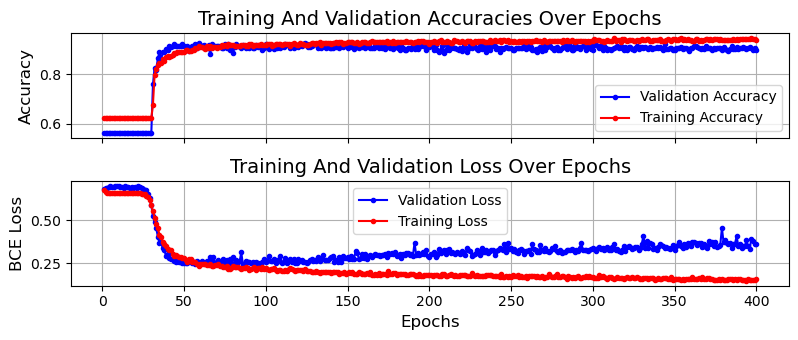

In [9]:
import matplotlib.pyplot as plt

epochs = np.arange(1, EPOCHS + 1)
# PLOT ACCURACIES
# Plot accuracies0
fig, ax = plt.subplots(2, 1, figsize=(8, 3.5), sharex=True)
ax[0].plot(epochs, all_valid_acc, marker='.', color='b', label='Validation Accuracy')
ax[0].plot(epochs, all_train_acc, marker='.', color='r', label='Training Accuracy')
ax[0].set_title('Training And Validation Accuracies Over Epochs', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].grid(True)
ax[0].legend()

# Plot losses
ax[1].plot(epochs, all_valid_loss, marker='.', color='b', label='Validation Loss')
ax[1].plot(epochs, all_train_loss, marker='.', color='r', label='Training Loss')
ax[1].set_title('Training And Validation Loss Over Epochs', fontsize=14)
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('BCE Loss', fontsize=12)
ax[1].grid(True)
ax[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [10]:
# evaluating on test dataset:
model = torch.load('mlp-model.pt')
avg_test_loss, test_acc = valid_epoch(test_dl)

/var/folders/pv/x97pt2hs4r57jwqqpz0z10_40000gn/T/ipykernel_17458/2389144475.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('mlp-model.pt')


In [11]:
avg_test_loss, test_acc

(0.27878990802556686, 0.8986301369863013)

## training all_features: 0.8835
### dropping:
"Father's qualification",
 'Gender',
 'Previous qualification (grade)',
 'International',
 'Curricular units 2nd sem (without evaluations)',
 'Marital Status',
 'GDP',
 'Displaced',
 'Debtor',
 'Inflation rate',
 "Mother's occupation",
 "Father's occupation",
 'Unemployment rate',
 'Previous qualification',
 'Curricular units 1st sem (without evaluations)',
 "Mother's qualification",
 'Curricular units 2nd sem (enrolled)',
 'Application order',
 'Age at enrollment',
 'Educational special needs','Nacionality'
## training after first feature removal: 0.9013
### dropping:
'Curricular units 1st sem (grade)', 'Curricular units 1st sem (evaluations)'
## training after second feature removal: 0.9082
### Dropping:
'Admission grade', 
'Daytime/evening attendance' 
## training after third feature removal: 0.8853
Will not drop admission and attendence variables


In [9]:
model = torch.load('/Users/alexiy/Projects/Purdue/cs573_proj/mlp-model.pt')


In [10]:
test_dl

NameError: name 'test_dl' is not defined

In [264]:
x_test.shape, y_test.shape

((726, 49), (726,))

In [265]:
unique_cols = set([col.split("_")[0] for col in x_test.columns])

# Data Feature Analysis

In [266]:
from tabulate import tabulate
def analyze_feature_importance(feature):
    cols = [col for col in x_test.columns if feature in col]
    df_copy = x_test.copy()
    test_dl = DataLoader(DropoutDS(x_test, y_test), batch_size=batch_size, shuffle=True)
    _, orig_test_acc = valid_epoch(test_dl)
    for col in cols:
        df_copy[col] = df_copy[col].sample(frac=1).reset_index(drop=True)
    test_dl = DataLoader(DropoutDS(df_copy, y_test), batch_size=batch_size, shuffle=True)
    _, removal_test_acc = valid_epoch(test_dl)
    return feature, orig_test_acc, removal_test_acc, removal_test_acc > orig_test_acc - 0.0005


headers = ["Feature", "Orig Acc", "Shuffled Acc", "Remove Feature"]
data = []
for col in unique_cols:
    feature, original_test_acc, removal_test_acc, remove_feature = analyze_feature_importance(col)
    data.append([feature, f"{original_test_acc:.4}", f"{removal_test_acc:.4}", remove_feature])

print(tabulate(data, headers=headers, tablefmt="grid"))
    

+----------------------------------------+------------+----------------+------------------+
| Feature                                |   Orig Acc |   Shuffled Acc | Remove Feature   |
+========================================+============+================+==================+
| Application mode                       |     0.9082 |         0.8986 | False            |
+----------------------------------------+------------+----------------+------------------+
| Curricular units 1st sem (enrolled)    |     0.9082 |         0.9027 | False            |
+----------------------------------------+------------+----------------+------------------+
| Curricular units 2nd sem (grade)       |     0.9082 |         0.8192 | False            |
+----------------------------------------+------------+----------------+------------------+
| Curricular units 1st sem (credited)    |     0.9082 |         0.8945 | False            |
+----------------------------------------+------------+----------------+--------

In [272]:
drop_features = [feat for feat, _, _, drop in data if drop]
keep_features = [feat for feat, _, _, drop in data if not drop]


In [273]:
print("features to drop:")
print(drop_features)
print("features to keep:")
print(keep_features)



features to drop:
['Admission grade', 'Daytime/evening attendance']
features to keep:
['Application mode', 'Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (credited)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Scholarship holder', 'Curricular units 2nd sem (credited)', 'Tuition fees up to date', 'Course', 'Curricular units 1st sem (approved)']


## 10 Fold Cross Validation

In [63]:
print(test_acc)

0.8821917808219178
